In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiment-prediction-on-movie-reviews/movies.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/sample.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/train.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/test.csv


# ****Loading The Dataset****

> In This Section :
> 
> 1. Loaded all CSV files into DataFrames,merged(left outer join) movies_data(metadata of movies) containing features like :
> * ('movieid','title','audienceScore','rating','ratingContents','releaseDateTheaters','releaseDateStreaming','runtimeMinutes','genre','originalLanguage','director', 'boxOffice', 'distributor','soundType')
> 
>    with train and test data containing features like :
> * ('movieid','reviewerName','isFrequentReviewer','reviewText','sentiment') and ('movieid','reviewerName','isTopCritic','reviewText') respectively.
> 
> 2. Dropped Duplicate Rows(rows with same values for all fatures and rows with same movieid seperately) From Movies.csv Before Merging DataFrames.
> 
> 3. Dropped Null Rows From Merged Dataset (rows for which no. of null features in range(8,11).

In [2]:
#movies.csv - the file with metadata on movies.
movies_data = pd.read_csv("/kaggle/input/sentiment-prediction-on-movie-reviews/movies.csv") 
#train.csv - the training set containing the review sentiment along with other features.
train_data = pd.read_csv("/kaggle/input/sentiment-prediction-on-movie-reviews/train.csv")
#test.csv - the test set, has review features, but no sentiment column, since it is the target.
test_data = pd.read_csv("/kaggle/input/sentiment-prediction-on-movie-reviews/test.csv")

In [3]:
#dropping redundant rows i.e. rows same values for all features from movies.csv and copying dataset into new variable .
dist_movdat = movies_data.drop_duplicates()
#further removing redundant rows using values of feature 'movieid' and keeping only last 'movieid' and respective feature.
dist_movdat = dist_movdat.drop_duplicates(subset =['movieid'],keep = 'last' )

In [4]:
#merging train and test datasets with movie data on 'movieid' seperately.
train_movdat = train_data.merge(dist_movdat,on = 'movieid',how ='left')
test_data_mov= test_data.merge(dist_movdat,on = 'movieid',how ='left')

In [5]:
"""for i in range(8,12):
    #dropping rows with null columns count 10 or 11.
    num_required_nan = i
    # Count the number of NaN values in each row
    subs = train_movdat[train_movdat.sentiment == "NEGATIVE"]
    nan_counts = subs.isna().sum(axis=1)
    # Filter the rows where the count of NaN values is equal to or greater than the specified number
    filtered_rows = subs[nan_counts >= num_required_nan]
    # Get the row indexes of the filtered rows
    required_nan_idx= filtered_rows.index"""
    # dropping the rows with null values on reviewText
train_movdat.dropna(subset =['reviewText'],inplace = True)
train_movdat.reset_index(drop=True,inplace = True)

In [6]:
train_movdat.shape

(156311, 18)

# ****Exploratory Data Analysis****

> **Exploratory Data Analysis (EDA) is an approach that is used to analyze the data and discover trends, patterns, or check assumptions in data with the help of statistical summaries and graphical representations.**

> In This Section,relationship between categorical and numerical features from merged train dataframe were analysed and visualised using plots and graphs.

In [7]:
#importing necessary libraries for data visualisations.
import seaborn as sns
import matplotlib.pyplot as plt

> Information Below suggests that : 
> * Train data (before merging) has 4 categorical features of object datatypes and 1 Boolean feature.
> * Movies Meta Data has 14 categorical features of object datatypes and 2 float64 (numerical) features and alot Null Values.

In [8]:
#checking data types and null values in train data and movies metadata.
train_data.info()
print("\n")
movies_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162758 entries, 0 to 162757
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   movieid             162758 non-null  object
 1   reviewerName        162758 non-null  object
 2   isFrequentReviewer  162758 non-null  bool  
 3   reviewText          156311 non-null  object
 4   sentiment           162758 non-null  object
dtypes: bool(1), object(4)
memory usage: 5.1+ MB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143258 entries, 0 to 143257
Data columns (total 14 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   movieid               143258 non-null  object 
 1   title                 143258 non-null  object 
 2   audienceScore         73248 non-null   float64
 3   rating                13991 non-null   object 
 4   ratingContents        13991 non-null   object 
 5   releaseDateTheat

> After deducing the information given below :
> * It is clear now that after merging datasets the new DataFrame has 17 features and 1 Target variable.
> * Out of 17 Features , 12 features conatins Null Values which will be treated in preprocessing stage.

In [9]:
#checking datafarame structure after merging raw train data and movies_data.
train_movdat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156311 entries, 0 to 156310
Data columns (total 18 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   movieid               156311 non-null  object 
 1   reviewerName          156311 non-null  object 
 2   isFrequentReviewer    156311 non-null  bool   
 3   reviewText            156311 non-null  object 
 4   sentiment             156311 non-null  object 
 5   title                 156311 non-null  object 
 6   audienceScore         144970 non-null  float64
 7   rating                97775 non-null   object 
 8   ratingContents        97775 non-null   object 
 9   releaseDateTheaters   123334 non-null  object 
 10  releaseDateStreaming  141056 non-null  object 
 11  runtimeMinutes        153599 non-null  float64
 12  genre                 154056 non-null  object 
 13  originalLanguage      153143 non-null  object 
 14  director              156311 non-null  object 
 15  

Using describe() to analyse statistics of numerical features audienceScore and runtimeMinutes on whole train_movdat(merged dataset) ,we get :


In [10]:
#description of numerical features present in merged dataset.
train_movdat.describe()

,audienceScore,runtimeMinutes
count,144970.000000,153599.000000
mean,65.039387,106.895143
std,19.815337,22.538135
min,0.000000,3.000000
25%,51.000000,93.000000
50%,68.000000,104.000000
75%,81.000000,118.000000
max,100.000000,561.000000


Using describe() to analyse statistics of numerical features audienceScore and runtimeMinutes on subset of train_movdat(merged dataset) where sentiments are positive and neagtive respectively,we get :

In [11]:
train_movdat[train_movdat.sentiment == 'POSITIVE'].describe()

,audienceScore,runtimeMinutes
count,96930.000000,102807.000000
mean,69.313886,107.563366
std,18.512736,23.420237
min,0.000000,3.000000
25%,57.000000,94.000000
50%,73.000000,105.000000
75%,84.000000,119.000000
max,100.000000,561.000000


In [12]:
train_movdat[train_movdat.sentiment == 'NEGATIVE'].describe()

,audienceScore,runtimeMinutes
count,48040.000000,50792.000000
mean,56.414759,105.542605
std,19.548401,20.571519
min,0.000000,3.000000
25%,42.000000,93.000000
50%,56.000000,103.000000
75%,72.000000,116.000000
max,100.000000,421.000000


In [13]:
train_movdat.sentiment.value_counts()

POSITIVE    104719
NEGATIVE     51592
Name: sentiment, dtype: int64

<Axes: xlabel='sentiment', ylabel='Count'>

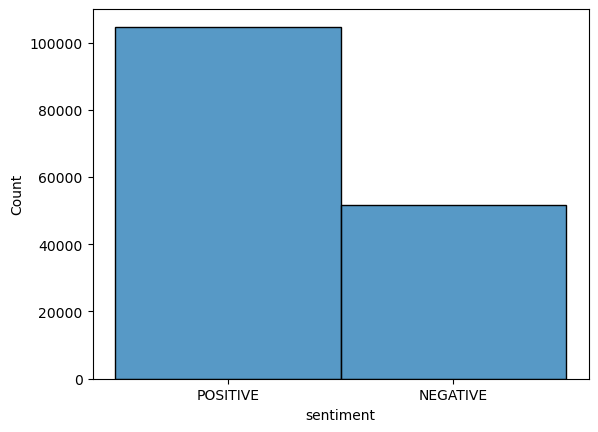

In [14]:
#countplot of target variable 'sentiment'
sns.histplot(train_movdat.sentiment,stat = "count")

In [15]:
#Top 20 review counts by movieid
train_data.movieid.value_counts().head(10)

escape_the_terminator_tyler_durden_astonish    708
fantasy_forrest_gump_intrigue                  245
james_t._kirk_marty_mcfly_astonish             186
marvelous_lara_croft_luke_skywalker            140
michael_corleone_v_marty_mcfly_tony_stark      138
quest_island_black_widow                       132
luke_skywalker_harry_potter_james_t._kirk      132
ellen_ripley_hiccup_captain_jack_sparrow       125
the_bride_zephyr_mystique                      113
miracle_john_wick_pirate                       112
Name: movieid, dtype: int64

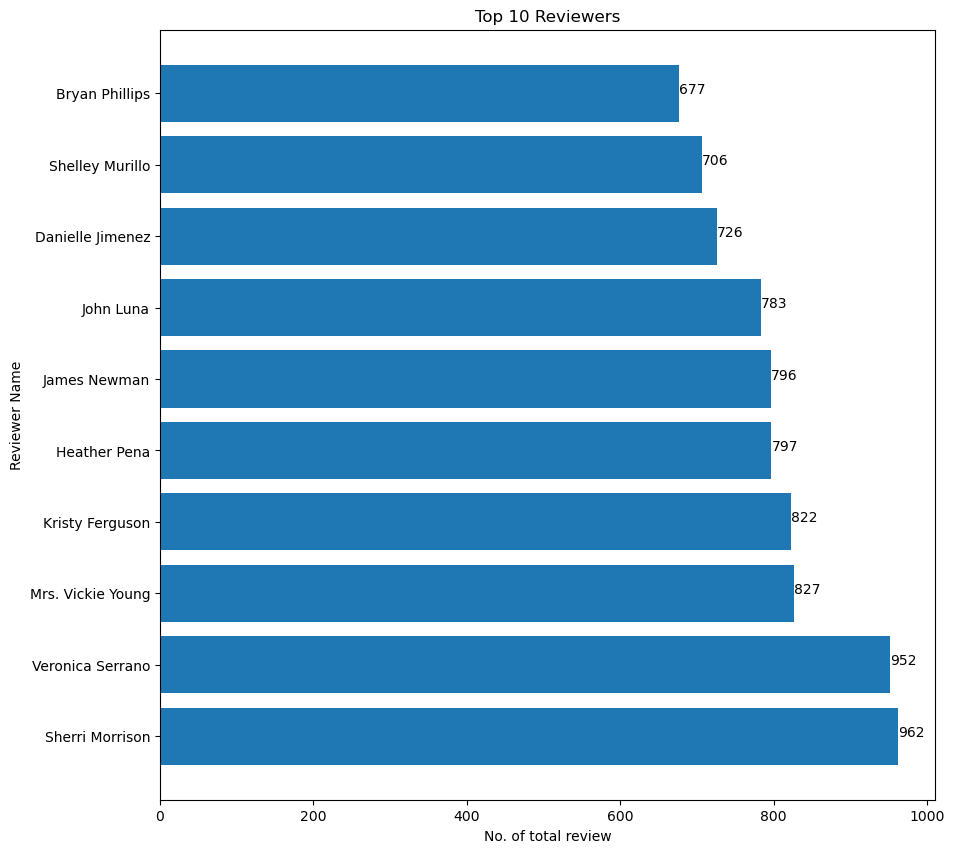

In [16]:
top_reviewer = train_data.reviewerName.value_counts().head(10)
series = pd.Series(top_reviewer, index = top_reviewer.index)
# creating the bar plot
plt.figure(figsize = (10,10))
plt.barh(series.index,series.values)
plt.ylabel("Reviewer Name")
plt.xlabel("No. of total review")
plt.title("Top 10 Reviewers")
for index, value in enumerate(series.values):
    plt.text(value, index,str(value))
plt.show()

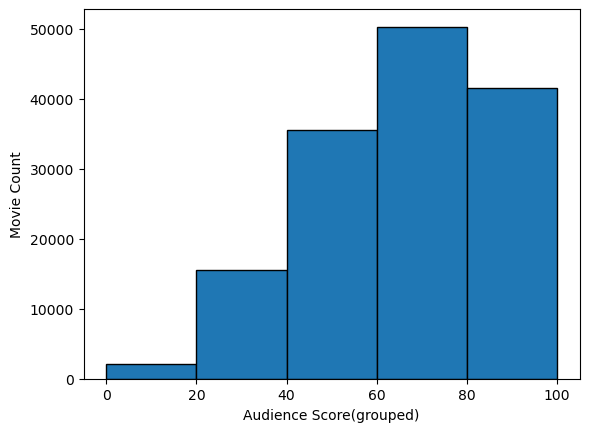

In [17]:
out = train_movdat.audienceScore
bins=[0,20,40,60,80,100]
plt.hist(out,bins = bins,edgecolor="k")
plt.ylabel("Movie Count")
plt.xlabel("Audience Score(grouped)")
plt.show()

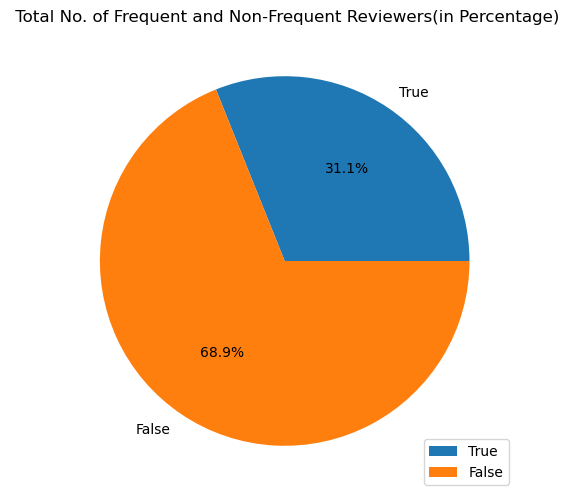

In [18]:
isFreqReviewer_true = len(train_movdat[train_movdat["isFrequentReviewer"] == True].copy())
isFreqReviewer_false = len(train_movdat[train_movdat["isFrequentReviewer"] == False].copy())
plt.figure(figsize =(6,6))
plt.pie([isFreqReviewer_true,isFreqReviewer_false],labels =["True","False"],autopct = '%.1f%%')
plt.title(" Total No. of Frequent and Non-Frequent Reviewers(in Percentage)")
plt.legend(loc ='lower right')
plt.show() 

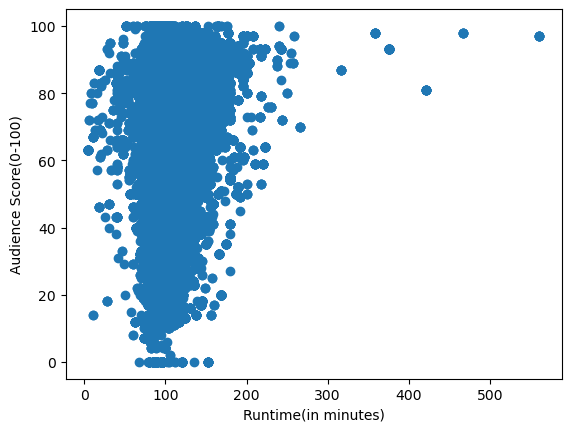

In [19]:
plt.scatter(train_movdat.runtimeMinutes,train_movdat.audienceScore)
plt.xlabel("Runtime(in minutes)")
plt.ylabel("Audience Score(0-100)")
plt.show()

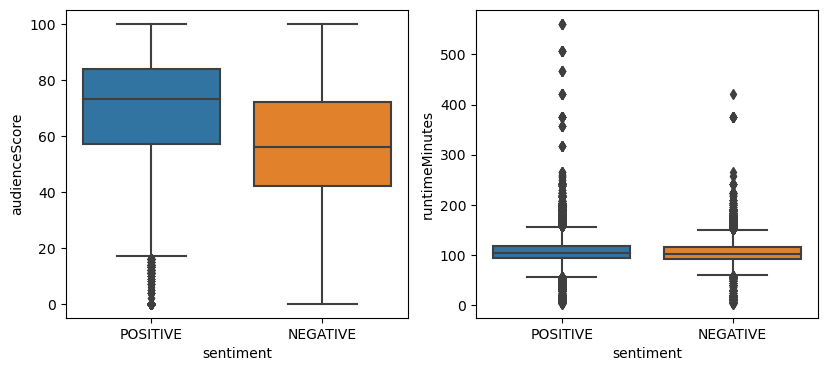

In [20]:
plt.figure(figsize = (15, 4))
plt.subplot(1,3,1)
sns.boxplot(x = 'sentiment', y ='audienceScore', data = train_movdat)
plt.subplot(1,3,2)
sns.boxplot(x = 'sentiment', y ='runtimeMinutes', data = train_movdat)
plt.show()

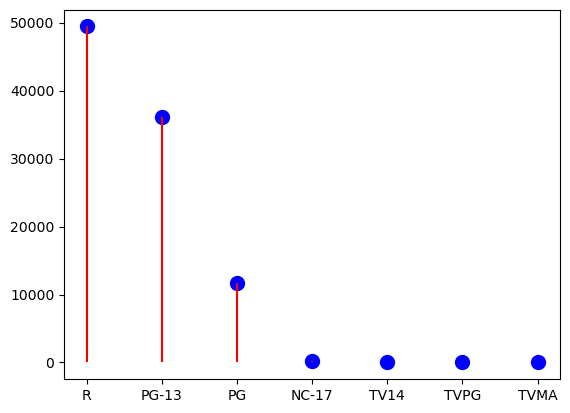

In [21]:
#lollipop chart for Ratings and count of movies belonging to respective rating.
cat = train_movdat.rating.value_counts().index.values
count = train_movdat.rating.value_counts().values
fig, ax = plt.subplots()
ax.vlines(cat, ymin=0, ymax=count, color='red')
ax.scatter(cat, count, color='blue', s=100)
plt.show()

# ****Data Cleaning/Preprocessing****

> In This Stage :
> *  Merged Data was split further in X(set of features) and y(Target Variable).
> *  Categorical Features of X are filled with NA (indicating not available) to avoid Inconsistency,ValueErrors during Model Training and Misleading   values.
> * Rename and Changed datatypes of some features to avoid errors while transforming test data using preprocessors and to get more usefulness in algorithm.
> * Cleaned ReviewText (document type feature containig movie reviews)by removing punctuations and digits.
> * Extracted year from date variables to help ML model in identifying the underlying pattern.
> * To tackle issue of NaN and NaT values in numerical features : numerical/datetime features imputed using KNNImputer.
> * for Feature selection ,correlation matrix was used to remove strongly correlated features,in the end, Final Encoded dataset is preprocessed using OneHotEncoder,CountVectorizer and TF-IDF Vectorizer (Term Frequency - Inverse Document Frequency is a handy algorithm that uses the frequency of words to determine how relevant those words are to a given document) and combined as sparse output (Using ColumnTransformer) for Model Training/Feature Selection.

In [22]:
#splitting training data in X(input data) and y(label),with high NaN values.
from sklearn.model_selection import train_test_split as tts
X,y,test_data = train_movdat.drop(['sentiment'],axis = 1),train_movdat["sentiment"],test_data_mov

In [23]:
#renaming features 'isFrequentReviewer' and 'isTopCritic' to 'isTopReviewer/Critic'
X = X.rename(columns = {'isFrequentReviewer':'isTopReviewer/Critic'})
test_data = test_data.rename(columns = {'isTopCritic':'isTopReviewer/Critic'})
cat_col = ['movieid','reviewerName','isTopReviewer/Critic','reviewText','title','rating','ratingContents','releaseDateTheaters',
 'releaseDateStreaming','genre','originalLanguage','director','distributor','soundType']
num_col = X.select_dtypes(include=['number']).columns.tolist()

In [24]:
#filling categorical columns with null value as 'NA' i.e. Not Available
X[cat_col] = X[cat_col].fillna("")
test_data[cat_col] = test_data[cat_col].fillna("")

In [25]:
#cleaning reviewText feature and removing unnecessary special characters.
import re

def clean_text(data,symbol):
    #Patterns ["#\S+","&\S+"] and ["#\Z","&\Z"] removes string group starting and ending with "#" and "&" respectively.
    if symbol == '#':
        for i in range(len(data)):
            data[i] = re.sub(r"#\S+", "",str(data[i]))
        return data
    if symbol == '#1':
        for i in range(len(data)):
            data[i] = re.sub(r"#\Z", "",str(data[i]))
        return data
    if symbol == '&1':
        for i in range(len(data)):
            data[i] = re.sub(r"&\Z", "",str(data[i]))
        return data
    if symbol == '&':
        for i in range(len(data)):
            data[i] = re.sub(r"&\S+", "",str(data[i]))
        return data
    #Pattern "[0-9]\S|[0-9]" removes numbers from string group.
    if symbol == 'num':
        for i in range(len(data)):
            data[i] = re.sub(r"[0-9]\S|[0-9]", "",str(data[i]))
        return data
    #Pattern "(\(.*\))|(\[.*\])" removes round and square brackets from string group.
    if symbol == 'braces':
        for i in range(len(data)):
            data[i] = re.sub(r"(\(.*\))|(\[.*\])", "",str(data[i]))
        return data

strs = ['#','#1','&','&1','num','braces']
for i in strs :
    X["reviewText"] = clean_text(X["reviewText"].copy(),i)
    test_data["reviewText"] = clean_text(test_data["reviewText"].copy(),i)

In [26]:
#converting list of strings into comma seperated strings.
rc_temp = X["ratingContents"].copy()
for i in range(len(rc_temp)):
    rc_temp[i] = str(rc_temp[i]).strip('][').split(',')
    rc_temp[i] = [string.strip('\'" ') for string in rc_temp[i]]
    rc_temp[i] = ','.join(rc_temp[i])
#X['ratingContents'] = rc_temp
X["ratingContents"] = rc_temp

In [27]:
#converting date features i.e.'releaseDateTheaters' and'releaseDateStreaming' into datetime dtype.
date_temp_train = X[['releaseDateTheaters','releaseDateStreaming']].copy().replace("NA",'NaT').astype('datetime64[ns]')
date_temp_test = test_data[['releaseDateTheaters','releaseDateStreaming']].copy().replace("NA",'NaT').astype('datetime64[ns]')
X['relyearT'] = date_temp_train['releaseDateTheaters'].dt.year
X['relyearS'] =date_temp_train['releaseDateStreaming'].dt.year
test_data['relyearT'] = date_temp_test['releaseDateTheaters'].dt.year
test_data['relyearS'] =date_temp_test['releaseDateStreaming'].dt.year
#dropping old date features
X = X.drop(['releaseDateTheaters','releaseDateStreaming'],axis = 1)
test_data = test_data.drop(['releaseDateTheaters','releaseDateStreaming'],axis = 1)

In [28]:
#cleaning 'boxOffice' feature and converting from string dtype to numerical dtype.
char_list = ['K']
bo_temp = X["boxOffice"].copy()
bo_temp_test = test_data["boxOffice"].copy()
bo_temp = bo_temp.str.replace('$',"",regex=True)
bo_temp_test = bo_temp_test.str.replace('$',"",regex=True)

def conv_mil_k(value):
    if 'M' in str(value):
        return float(value.replace('M', '')) * 1000000
    elif 'K' in str(value):
        return float(value.replace('K', '')) * 1000
    elif value == np.nan:
        return value
bo_temp = bo_temp.apply(conv_mil_k)
bo_temp_test = bo_temp_test.apply(conv_mil_k)

X.boxOffice = bo_temp
test_data.boxOffice = bo_temp_test

<Axes: >

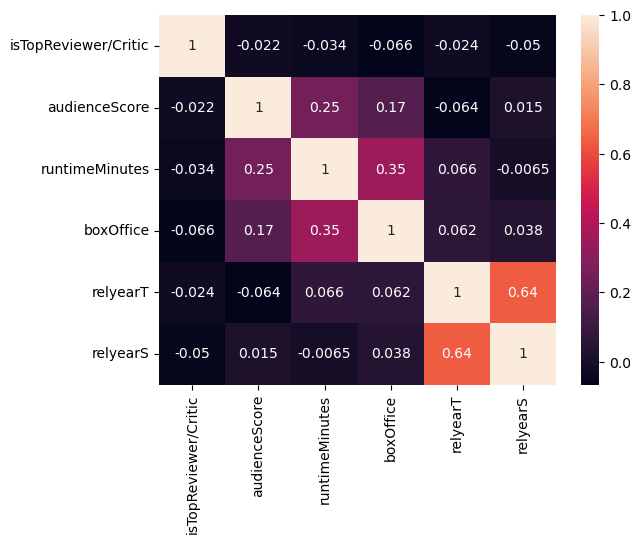

In [29]:
sns.heatmap(X.corr(numeric_only = True),annot = True)

In [30]:
# splitting the data into train set and validation set.
X_train,X_test,y_train,y_test= tts(X,y,random_state = 42,test_size = 0.33)

In [31]:
num_col = X.select_dtypes(include=['number']).columns.tolist()

In [32]:
#MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
mmscale = MinMaxScaler()
X_train[num_col] = mmscale.fit_transform(X_train[num_col])
X_test[num_col] = mmscale.transform(X_test[num_col])
test_data[num_col] = mmscale.transform(test_data[num_col])

In [33]:
#imputing the null values of numerical features using K-Nearest Neighbours Imputer.
from sklearn.impute import KNNImputer
kimp = KNNImputer(n_neighbors = 5)
to_imp = X_train.select_dtypes(include=['number']).columns.tolist()
X_train[to_imp] = kimp.fit_transform(X_train[to_imp])
X_test[to_imp] = kimp.transform(X_test[to_imp])
test_data[to_imp] = kimp.transform(test_data[to_imp])

In [34]:
X_train.drop(['isTopReviewer/Critic','relyearT','relyearS'],axis = 1,inplace = True )
X_test.drop(['isTopReviewer/Critic','relyearT','relyearS'],axis = 1,inplace = True )
test_data.drop(['isTopReviewer/Critic','relyearT','relyearS'],axis = 1,inplace = True)

In [35]:
X_train.drop(['soundType'],axis = 1,inplace = True )
X_test.drop(['soundType'],axis = 1,inplace = True )
test_data.drop(['soundType'],axis = 1,inplace = True)

In [36]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
ohe_list = ['movieid','reviewerName','originalLanguage']
transformers = [("ohe",OneHotEncoder(handle_unknown = 'ignore'),ohe_list),
                ("tfid",TfidfVectorizer(ngram_range= (1,2)),'reviewText'),
                ("tfid_2",TfidfVectorizer(),'ratingContents'),
                ("tfid_3",TfidfVectorizer(),'genre'),
                ("tfid_4",TfidfVectorizer(),'title'),
                ("tfid_6",TfidfVectorizer(),'distributor'),
                ("tfid_7",TfidfVectorizer(),'director'),
                ("tfid_8",TfidfVectorizer(),'rating'),
                #("tfid_9",TfidfVectorizer(),)
                #('orenc',OrdinalEncoder(handle_unknown = 'use_encoded_value',unknown_value = np.nan),['rating']),
               ]
ct = ColumnTransformer(transformers,remainder = "passthrough")
X_train_enc = ct.fit_transform(X_train)
X_test_enc = ct.transform(X_test)
test_enc = ct.transform(test_data)

In [37]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectPercentile
from sklearn.pipeline import Pipeline
vts = VarianceThreshold()
skp = SelectPercentile(percentile = 55)
pipe = Pipeline(steps = [("vts",vts),("skp",skp)])
X_train_enc = pipe.fit_transform(X_train_enc,y_train)
X_test_enc = pipe.transform(X_test_enc)
test_enc = pipe.transform(test_enc)

In [38]:
print(X_train_enc.shape)

(104728, 453395)


# ****ML Model Training****

> In This Stage :
> * 3 Best Performing Models (In Terms of accuracy of both labels) were trained with some parameters initially, The Models We Trained :

> 1. Logistic Regression :  Logistic Regression ,also known as logit model is a machine learning algorithm often used for binary classification and predictive analytics.In This project,Logistic regression is estimating the probability of getting NEGATIVE or POSITIVE sentiment, based on critics reviews and other features.

> 2. Linear SVC :  It is Linear Support Vector Classification. It is similar to SVC having kernel = ‘linear’. The difference between them is that LinearSVC implemented in terms of library called liblinear while SVC is implemented in libsvm.The main goal of LinearSVC is to divide the dataset into number of classes (in our case 2 classes) in order to find a maximum marginal hyperplane (MMH) which seperates sepeartes classes and classify unseen data accordingly.

> 3. SGDClassifier : SGDClassifier is a classification algorithm used in machine learning that belongs to the family of linear models. The fitting algorithm Stochastic Gradient Descent (SGD) finds the optimal coefficients of the linear classifiers by updating the model’s parameters using the gradient of the loss function. The algorithm is beneficial for handling large-scale datasets, as it updates the model parameters on samples of observations rather than using the entire dataset, which can be computationally expensive.



In [39]:
#importing necessary libraries
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import LinearSVC

In [40]:
lr1 = LogisticRegression(solver = 'liblinear',C = 6,max_iter = 20000,random_state = 42)
lr1.fit(X_train_enc,y_train)
lr1.score(X_test_enc,y_test)

0.8396370897388674

In [41]:
y_pred_lr = lr1.predict(X_test_enc)
labels = ['POSITIVE', 'NEGATIVE']
print(classification_report(y_test, y_pred_lr, labels=labels))

              precision    recall  f1-score   support

    POSITIVE       0.86      0.91      0.88     34617
    NEGATIVE       0.79      0.69      0.74     16966

    accuracy                           0.84     51583
   macro avg       0.83      0.80      0.81     51583
weighted avg       0.84      0.84      0.84     51583



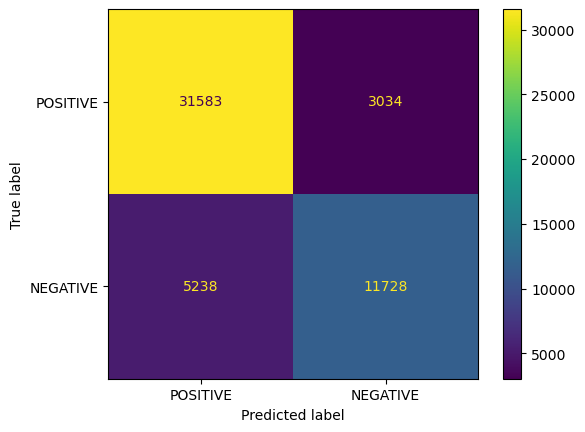

In [42]:
cm_lr= confusion_matrix(y_test, y_pred_lr, labels=labels)
disp_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr,display_labels=labels)
disp_lr.plot()
plt.show()

In [43]:
lsvc = LinearSVC(C =.33,max_iter = 30000,tol = 1e-10, dual = True)
lsvc.fit(X_train_enc,y_train)
lsvc.score(X_test_enc,y_test)

0.8404513114785879

In [44]:
y_pred_lsvc = lsvc.predict(X_test_enc)
labels = ['POSITIVE', 'NEGATIVE']
print(classification_report(y_test, y_pred_lsvc, labels=labels))

              precision    recall  f1-score   support

    POSITIVE       0.86      0.91      0.88     34617
    NEGATIVE       0.79      0.69      0.74     16966

    accuracy                           0.84     51583
   macro avg       0.83      0.80      0.81     51583
weighted avg       0.84      0.84      0.84     51583



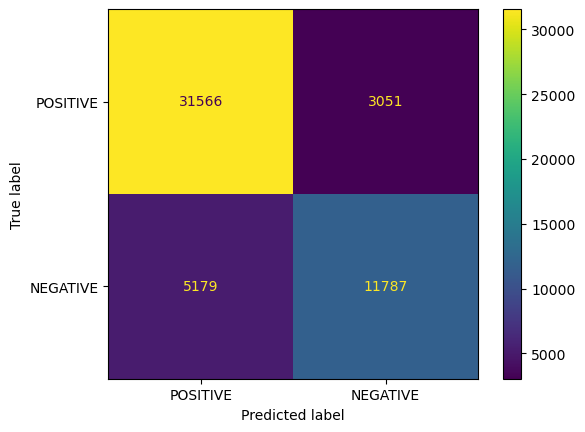

In [45]:
cm_lsvc= confusion_matrix(y_test, y_pred_lsvc, labels=labels)
disp_lsvc = ConfusionMatrixDisplay(confusion_matrix=cm_lsvc,display_labels=labels)
disp_lsvc.plot()
plt.show()

In [46]:
sgd_clf = SGDClassifier(loss = 'modified_huber')
sgd_clf.fit(X_train_enc,y_train)
sgd_clf.score(X_test_enc,y_test)

0.8324060252408739

In [47]:
y_pred_sgd = sgd_clf.predict(X_test_enc)
labels = ['POSITIVE', 'NEGATIVE']
print(classification_report(y_test, y_pred_sgd, labels=labels))

              precision    recall  f1-score   support

    POSITIVE       0.86      0.89      0.88     34617
    NEGATIVE       0.76      0.71      0.74     16966

    accuracy                           0.83     51583
   macro avg       0.81      0.80      0.81     51583
weighted avg       0.83      0.83      0.83     51583



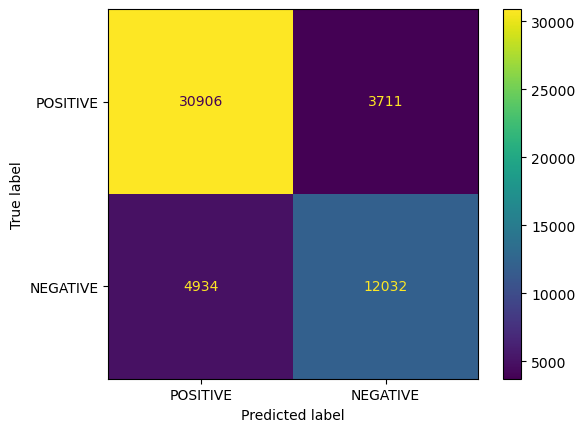

In [48]:
cm_sgd= confusion_matrix(y_test, y_pred_sgd, labels=labels)
disp_sgd = ConfusionMatrixDisplay(confusion_matrix=cm_sgd,display_labels=labels)
disp_sgd.plot()
plt.show()

# Hyper Parameter Tuning.

Tuning important parameters of best two models :
* 1.Logistic Regression.
* 2.Linear SVM.

In [49]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

In [50]:
param_grid1 = { 'C' : np.arange(5,15,0.5)}
lrgv = GridSearchCV(LogisticRegression(solver = 'liblinear',max_iter = 40000,random_state = 42),cv = 2,scoring = 'f1_micro',n_jobs = -1,param_grid = param_grid1)
lrgv.fit(X_train_enc,y_train)
lrgv.score(X_test_enc,y_test)

0.838629005680166

In [51]:
param_grid2 = { 'C' :np.arange(0.1,0.4,0.01)}
lsgv = GridSearchCV(LinearSVC(max_iter = 40000,tol = 1e-10,dual = True),cv=2,scoring='f1_micro',n_jobs = -1,param_grid = param_grid2)
lsgv.fit(X_train_enc,y_train)
lsgv.score(X_test_enc,y_test)

0.840102359304422

# ****Submitting To Competition****

In [52]:
#predicting test data using best model.
y_pred_final = lsvc.predict(test_enc)

In [53]:
#submitting the predictions of final model.
submission = pd.DataFrame(columns = ["id","sentiment"])
submission["id"] = [i for i in range(len(y_pred_final))]
submission["sentiment"] = y_pred_final
submission.to_csv('submission.csv',index = False)

# **The End**